In [2]:
'''
Compare the taxi carpool and food delivery system
focus on waiting time and on-road time
Yi Ding
06/06/18
'''

import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Read in data
rideaustin = pd.read_csv(
    '/Users/eleme-yi/Documents/PhD/GitHub Pages/dymodi.github.io/Research/Beacon/data/rideshare/Rides_DataA.csv')
rideaustin['uid'] = rideaustin.index
# print(rideaustin.head())

elemedata = pd.read_excel(
    # '/Users/eleme-yi/Documents/PhD/GitHub Pages/dymodi.github.io/Research/Beacon/data/rideshare/eleme_data.xlsx')
    '/Users/eleme-yi/Documents/PhD/GitHub Pages/dymodi.github.io/Research/Beacon/data/rideshare/eleme_data_overtime.xlsx')
elemedata['uid'] = elemedata.index
# print(elemedata.head())

In [4]:
# Convert to datetime
# Warning: Very time-consuming
# Taxi data
df_datetime = pd.DataFrame()
df_datetime['uid'] = rideaustin.index
df_datetime['created_on'] = pd.to_datetime(rideaustin.created_date)
df_datetime['driver_reached_on'] = pd.to_datetime(rideaustin.driver_reached_on)
df_datetime['started_on'] = pd.to_datetime(rideaustin.started_on)
df_datetime['completed_on'] = pd.to_datetime(rideaustin.completed_on)
df_datetime['updated_on'] = pd.to_datetime(rideaustin.updated_date)
# print(df_datetime.head())

# Eleme data
df_datetime_eleme = pd.DataFrame()
df_datetime_eleme['uid'] = elemedata.index
df_datetime_eleme['accept_at'] = pd.to_datetime(elemedata.accept_at)
df_datetime_eleme['arrive_rst_at'] = pd.to_datetime(elemedata.arrive_rst_at)
# df_datetime_eleme['arrive_rst_at'] = pd.to_datetime(elemedata.arrive_rst_at_beacon)
df_datetime_eleme['pickup_at'] = pd.to_datetime(elemedata.pickup_at)
# df_datetime_eleme['pickup_at'] = pd.to_datetime(elemedata.leave_rst_at_beacon)
df_datetime_eleme['deliver_at'] = pd.to_datetime(elemedata.deliver_at)
# print(df_datetime_eleme.head())

In [5]:
# Check NaN in datetime dataframe
df_datetime.dropna(inplace=True)
if df_datetime.isnull().values.any():
    raise Exception('Still has NaN?')
if df_datetime_eleme.isnull().values.any():
    raise Exception('Still has NaN in eleme data?')

Exception: Still has NaN in eleme data?

In [6]:
# Convert to timestamp
# Taxi data
df_timestamp = pd.DataFrame()
df_timestamp['uid'] = df_datetime.uid
df_timestamp['created_on'] = df_datetime.created_on.values.astype(np.int64) // 10 ** 9
df_timestamp['driver_reached_on'] = df_datetime.driver_reached_on.values.astype(np.int64) // 10 ** 9
df_timestamp['started_on'] = df_datetime.started_on.values.astype(np.int64) // 10 ** 9
df_timestamp['completed_on'] = df_datetime.completed_on.values.astype(np.int64) // 10 ** 9
df_timestamp['updated_on'] = df_datetime.updated_on.values.astype(np.int64) // 10 ** 9
print(df_timestamp.head())
# Eleme data
df_timestamp_eleme = pd.DataFrame()
df_timestamp_eleme['uid'] = df_datetime_eleme.uid
df_timestamp_eleme['accept_at'] = df_datetime_eleme.accept_at.values.astype(np.int64) // 10 ** 9
df_timestamp_eleme['arrive_rst_at'] = df_datetime_eleme.arrive_rst_at.values.astype(np.int64) // 10 ** 9
df_timestamp_eleme['pickup_at'] = df_datetime_eleme.pickup_at.values.astype(np.int64) // 10 ** 9
df_timestamp_eleme['deliver_at'] = df_datetime_eleme.deliver_at.values.astype(np.int64) // 10 ** 9
print(df_timestamp_eleme.head())

   uid  created_on  driver_reached_on  started_on  completed_on  updated_on
0    0  1465017019         1465017251  1465017529    1465018052  1465018068
1    1  1465022859         1465023002  1465023012    1465023109  1465023120
2    2  1465027987         1465028161  1465028162    1465028277  1465028287
3    3  1465051955         1465052479  1465052713    1465053218  1465053240
4    4  1465053805         1465053855  1465053865    1465053967  1465053976
   uid   accept_at  arrive_rst_at   pickup_at  deliver_at
0    0  1530127472     1530128052  1530128055  1530129434
1    1  1530097704     1530098790  1530098803  1530099996
2    2  1530098178     1530098706  1530099017  1530099813
3    3  1530101318     1530101334  1530101927  1530103246
4    4  1530101902     1530101926  1530102157  1530103722


In [7]:
# Get time difference
# Taxi data
df_timediff = pd.DataFrame()
df_timediff['uid'] = df_timestamp.uid
df_timediff['wait_time'] = (df_timestamp.started_on-df_timestamp.driver_reached_on)
df_timediff['drive_time'] = (df_timestamp.completed_on-df_timestamp.started_on)
df_timediff['wait_ratio'] = df_timediff['wait_time']/df_timediff['drive_time']
print('TAXI data head')
print(df_timediff.head())
# Eleme data
df_timediff_eleme = pd.DataFrame()
df_timediff_eleme['uid'] = df_timestamp.uid
df_timediff_eleme['wait_time'] = (df_timestamp_eleme.pickup_at-df_timestamp_eleme.arrive_rst_at)
df_timediff_eleme['drive_time'] = (df_timestamp_eleme.deliver_at-df_timestamp_eleme.pickup_at)
df_timediff_eleme['wait_ratio'] = df_timediff_eleme['wait_time']/df_timediff_eleme['drive_time']
print('ELEME data head')
print(df_timediff_eleme.head())

TAXI data head
   uid  wait_time  drive_time  wait_ratio
0    0        278         523    0.531549
1    1         10          97    0.103093
2    2          1         115    0.008696
3    3        234         505    0.463366
4    4         10         102    0.098039
ELEME data head
   uid  wait_time  drive_time  wait_ratio
0    0        3.0      1379.0    0.002175
1    1       13.0      1193.0    0.010897
2    2      311.0       796.0    0.390704
3    3      593.0      1319.0    0.449583
4    4      231.0      1565.0    0.147604


In [8]:
# Remove invalid values
# drive_time = 0 or wait_time = 0?
# Taxi
df_timediff = df_timediff[df_timediff.wait_time > 0]
df_timediff = df_timediff[df_timediff.drive_time > 0]
# EleMe
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_time > 0]
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.drive_time > 0]

Boxplot before removing outliers


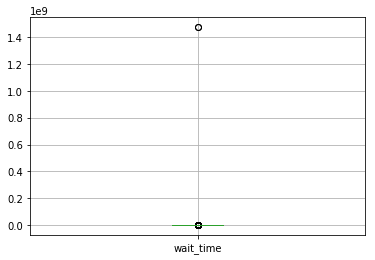

In [9]:
# Boxplot to have a first glance
print('Boxplot before removing outliers')
df_timediff.boxplot(column='wait_time')
plt.show()

TAXI data, length before removing outliers: 1491209
TAXI data, length after removing outliers: 1287770
TAXI data, 0.0  of total data removed.


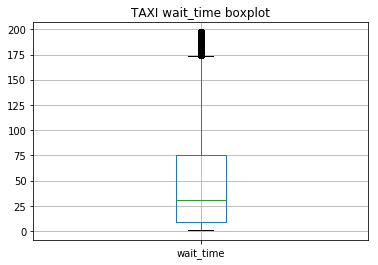

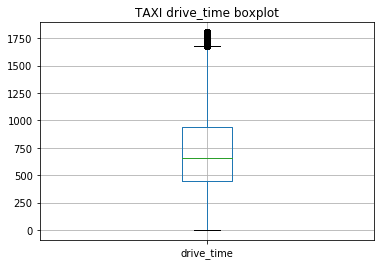

ELEME data, length before removing outliers: 9909
ELEME data, length after removing outliers: 9360
ELEME data, 0.0  of total data removed.


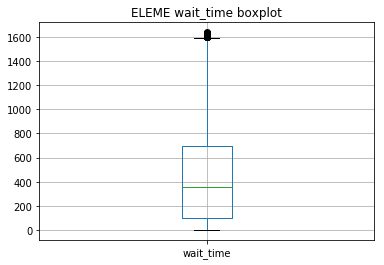

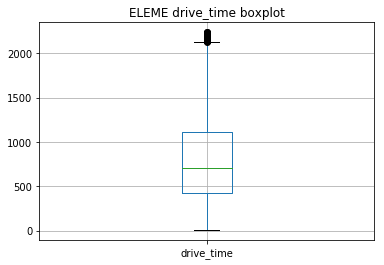

In [11]:
# Remove outliers (Standard Deviation method)
# Taxi
converged_taxi = 0
print('TAXI data, length before removing outliers:', len(df_timediff.index))
while converged_taxi == 0:
    len_before_taxi = len(df_timediff.index)
    
    wait_time_mean = df_timediff.wait_time.mean()
    wait_time_std = df_timediff.wait_time.std()
    drive_time_mean = df_timediff.drive_time.mean()
    drive_time_std = df_timediff.drive_time.std()
    wait_ratio_mean = df_timediff.wait_ratio.mean()
    wait_ratio_std = df_timediff.wait_ratio.std()
    df_timediff = df_timediff[df_timediff.wait_time > wait_time_mean - 3*wait_time_std]
    df_timediff = df_timediff[df_timediff.wait_time < wait_time_mean + 3*wait_time_std]
    df_timediff = df_timediff[df_timediff.drive_time > drive_time_mean - 3*drive_time_std]
    df_timediff = df_timediff[df_timediff.drive_time < drive_time_mean + 3*drive_time_std]
    # df_timediff = df_timediff[df_timediff.wait_ratio > wait_ratio_mean - 3*wait_ratio_std]
    # df_timediff = df_timediff[df_timediff.wait_ratio < wait_ratio_mean + 3*wait_ratio_std]
    if len_before_taxi == len(df_timediff.index):
        converged_taxi = 1
print('TAXI data, length after removing outliers:', len(df_timediff.index))
print('TAXI data,', round((len_before_taxi-len(df_timediff.index))/len_before_taxi,3),' of total data removed.')
# Boxplot to have a first glance
df_timediff.boxplot(column='wait_time')
plt.title('TAXI wait_time boxplot')
plt.show()
df_timediff.boxplot(column='drive_time')
plt.title('TAXI drive_time boxplot')
plt.show()

# ELE.ME
print('ELEME data, length before removing outliers:', len(df_timediff_eleme.index))
converged_eleme = 0
while converged_eleme == 0:
    len_before_eleme = len(df_timediff_eleme.index)  
    wait_time_eleme_mean = df_timediff_eleme.wait_time.mean()
    wait_time_eleme_std = df_timediff_eleme.wait_time.std()
    drive_time_eleme_mean = df_timediff_eleme.drive_time.mean()
    drive_time_eleme_std = df_timediff_eleme.drive_time.std()
    wait_ratio_eleme_mean = df_timediff_eleme.wait_ratio.mean()
    wait_ratio_eleme_std = df_timediff_eleme.wait_ratio.std()
    df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_time > wait_time_eleme_mean - 3*wait_time_eleme_std]
    df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_time < wait_time_eleme_mean + 3*wait_time_eleme_std]
    df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.drive_time > drive_time_eleme_mean - 3*drive_time_eleme_std]
    df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.drive_time < drive_time_eleme_mean + 3*drive_time_eleme_std]
    # df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_ratio > wait_ratio_eleme_mean - 3*wait_ratio_eleme_std]
    # df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_ratio < wait_ratio_eleme_mean + 3*wait_ratio_eleme_std]
    if len_before_eleme == len(df_timediff_eleme.index):
        converged_eleme = 1
print('ELEME data, length after removing outliers:', len(df_timediff_eleme.index))
print('ELEME data,', round((len_before_eleme-len(df_timediff_eleme.index))/len_before_eleme,3),' of total data removed.')
# Boxplot to have a first glance
df_timediff_eleme.boxplot(column='wait_time')
plt.title('ELEME wait_time boxplot')
plt.show()
df_timediff_eleme.boxplot(column='drive_time')
plt.title('ELEME drive_time boxplot')
plt.show()

In [12]:
# Remove outliers (kmeans)
from sklearn.cluster import KMeans
wait_time_taxi_array = np.int64(df_timediff.drop(['uid','wait_ratio'], axis=1).values)
print(wait_time_taxi_array.dtype)
print(wait_time_taxi_array)

kmeans = KMeans(n_clusters=2).fit(wait_time_taxi_array)
labels = kmeans.labels_
print(np.sum(labels))

int64
[[ 10  97]
 [  1 115]
 [ 10 102]
 ..., 
 [ 44 478]
 [  4 588]
 [  5 168]]
850996


TAXI data summary
wait_time_mean: 48.9492587962
wait_time_std: 49.4211286204
drive_time_mean: 719.857662471
drive_time_std: 361.164383079
wait_ratio_mean: 0.176386718501
wait_ratio_std: 2.25182684248
ELEME data summary
wait_time_eleme_mean: 447.489102564
wait_time_eleme_std: 397.387113924
drive_time_eleme_mean: 814.537393162
drive_time_eleme_std: 474.68919327
wait_ratio_eleme_mean: 0.873881749584
wait_ratio_eleme_std: 2.95752670629


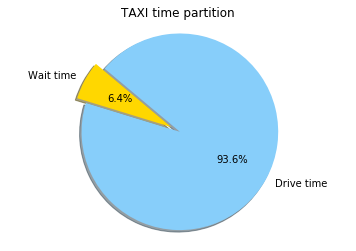

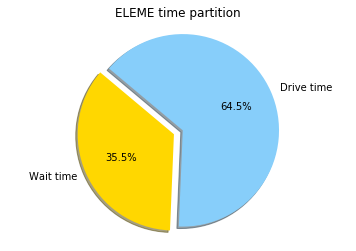

timediff_sort sample order by wait_ratio desc
             uid  wait_time  drive_time  wait_ratio
1267375  1267375        197           1       197.0
515864    515864        196           1       196.0
200635    200635        196           1       196.0
379883    379883        196           1       196.0
454891    454891        195           1       195.0
154047    154047        195           1       195.0
398563    398563        195           1       195.0
146094    146094        194           1       194.0
15261      15261        193           1       193.0
167311    167311        192           1       192.0
timediff_eleme_sort sample order by wait_ratio desc ELEME
       uid  wait_time  drive_time  wait_ratio
5102  5102     1232.0         7.0  176.000000
860    860     1088.0        11.0   98.909091
8099  8099      856.0         9.0   95.111111
8723  8723     1176.0        13.0   90.461538
2542  2542      742.0        10.0   74.200000
3913  3913     1042.0        15.0   69.466667
95

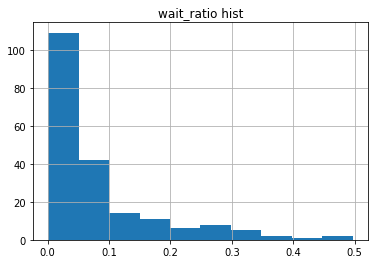

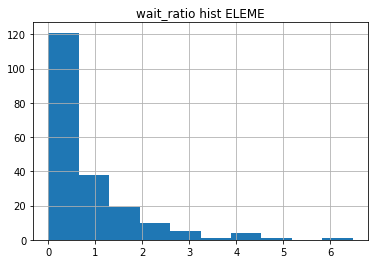

In [13]:
# # Show some special cases
# num_longer_than_1hour = 0
# for index, row in df_timediff.iterrows():
#     if row['wait_time'] > 3600:
# #         print('Wait more than 1 hour?')
# #         print('[row[uid]', row['uid'])
# #         raw_row = rideaustin.loc[rideaustin['uid'] == row['uid']]
# #         datatime_row = df_datetime.loc[df_datetime['uid'] == row['uid']]
# #         print('df_datetime')
# #         print(datatime_row)
# #         print('rideaustin')
# #         print(raw_row)
# #         print('-------------------------------------------')
#         num_longer_than_1hour = num_longer_than_1hour + 1        
# print(num_longer_than_1hour)

# Print result
# Taxi
print('TAXI data summary')
print('wait_time_mean:',df_timediff.wait_time.mean())
print('wait_time_std:', df_timediff.wait_time.std())
print('drive_time_mean:', df_timediff.drive_time.mean())
print('drive_time_std:', df_timediff.drive_time.std())
print('wait_ratio_mean:', df_timediff.wait_ratio.mean())
print('wait_ratio_std:', df_timediff.wait_ratio.std())
# ELEME
print('ELEME data summary')
print('wait_time_eleme_mean:', df_timediff_eleme.wait_time.mean())
print('wait_time_eleme_std:', df_timediff_eleme.wait_time.std())
print('drive_time_eleme_mean:', df_timediff_eleme.drive_time.mean())
print('drive_time_eleme_std:', df_timediff_eleme.drive_time.std())
print('wait_ratio_eleme_mean:', df_timediff_eleme.wait_ratio.mean())
print('wait_ratio_eleme_std:', df_timediff_eleme.wait_ratio.std())

# Pie Chart
# Taxi
labels = ['Wait time', 'Drive time']
sizes = [df_timediff.wait_time.mean(),df_timediff.drive_time.mean()]
colors = ['gold','lightskyblue']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140) 
plt.axis('equal')
plt.title('TAXI time partition')
plt.show()
# Eleme
sizes = [df_timediff_eleme.wait_time.mean(),df_timediff_eleme.drive_time.mean()]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140) 
plt.axis('equal')
plt.title('ELEME time partition')
plt.show()


# # Get some sample to have a insight
# # Taxi 
timediff_sample = df_timediff.sample(n=200)
# print(timediff_sample)
print('timediff_sort sample order by wait_ratio desc')
timediff_sort = df_timediff.sort_values(by='wait_ratio', ascending=False)
print(timediff_sort.head(10))
# ELEME
timediff_eleme_sample = df_timediff_eleme.sample(n=200)
print('timediff_eleme_sort sample order by wait_ratio desc ELEME')
timediff_eleme_sort = df_timediff_eleme.sort_values(by='wait_ratio', ascending=False)
print(timediff_eleme_sort.head(10))
# 为什么wait_ratio的mean和std是inf和nan？

# # Hist of wait time
# Taix
timediff_sample.hist('wait_ratio', bins=10)
plt.title('wait_ratio hist')
plt.show()
# ELEME
timediff_eleme_sample.hist('wait_ratio', bins=10)
plt.title('wait_ratio hist ELEME')
plt.show()